# 데이터 다운로드

In [1]:
# !chmod 600 /teamspace/studios/this_studio/kaggle.json

In [2]:
# import os

# os.environ["KAGGLE_CONFIG_DIR"] = "/teamspace/studios/this_studio"

In [3]:
# !kaggle competitions download -c ieee-fraud-detection -p data

 86%|███████████████████████████████████▍     | 102M/118M [00:00<00:00, 274MB/s]
100%|█████████████████████████████████████████| 118M/118M [00:00<00:00, 268MB/s]


In [4]:
# import zipfile

# # ZIP 파일 경로
# zip_path = '/teamspace/studios/this_studio/IEEE Fraud Detection/data/ieee-fraud-detection.zip'

# # 압축 풀기
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/teamspace/studios/this_studio/IEEE Fraud Detection/data')

# # 선택사항: 압축 해제 후 zip 파일 삭제
# os.remove(zip_path)

# Overview

In [5]:
# !pip install plotnine

In [6]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [7]:
train_idf = pd.read_csv("data/train_identity.csv")
train_trans = pd.read_csv("data/train_transaction.csv")
test_idf = pd.read_csv("data/test_identity.csv")
test_trans = pd.read_csv("data/test_transaction.csv")

test_trans["isFraud"] = -1

train_trans = train_trans.merge(train_idf, on="TransactionID", how="left")
test_trans = test_trans.merge(train_idf, on="TransactionID", how="left")

train_trans["type"] = "train"
test_trans["type"] = "test"

df = pd.concat([train_trans, test_trans], axis=0)
del train_trans, test_trans

# EDA

## isFraud - 타겟 컬럼 분포

In [8]:
fraud_dist = df.loc[df["type"]=="train", "isFraud"].value_counts()
fraud_dist

isFraud
0    569877
1     20663
Name: count, dtype: int64

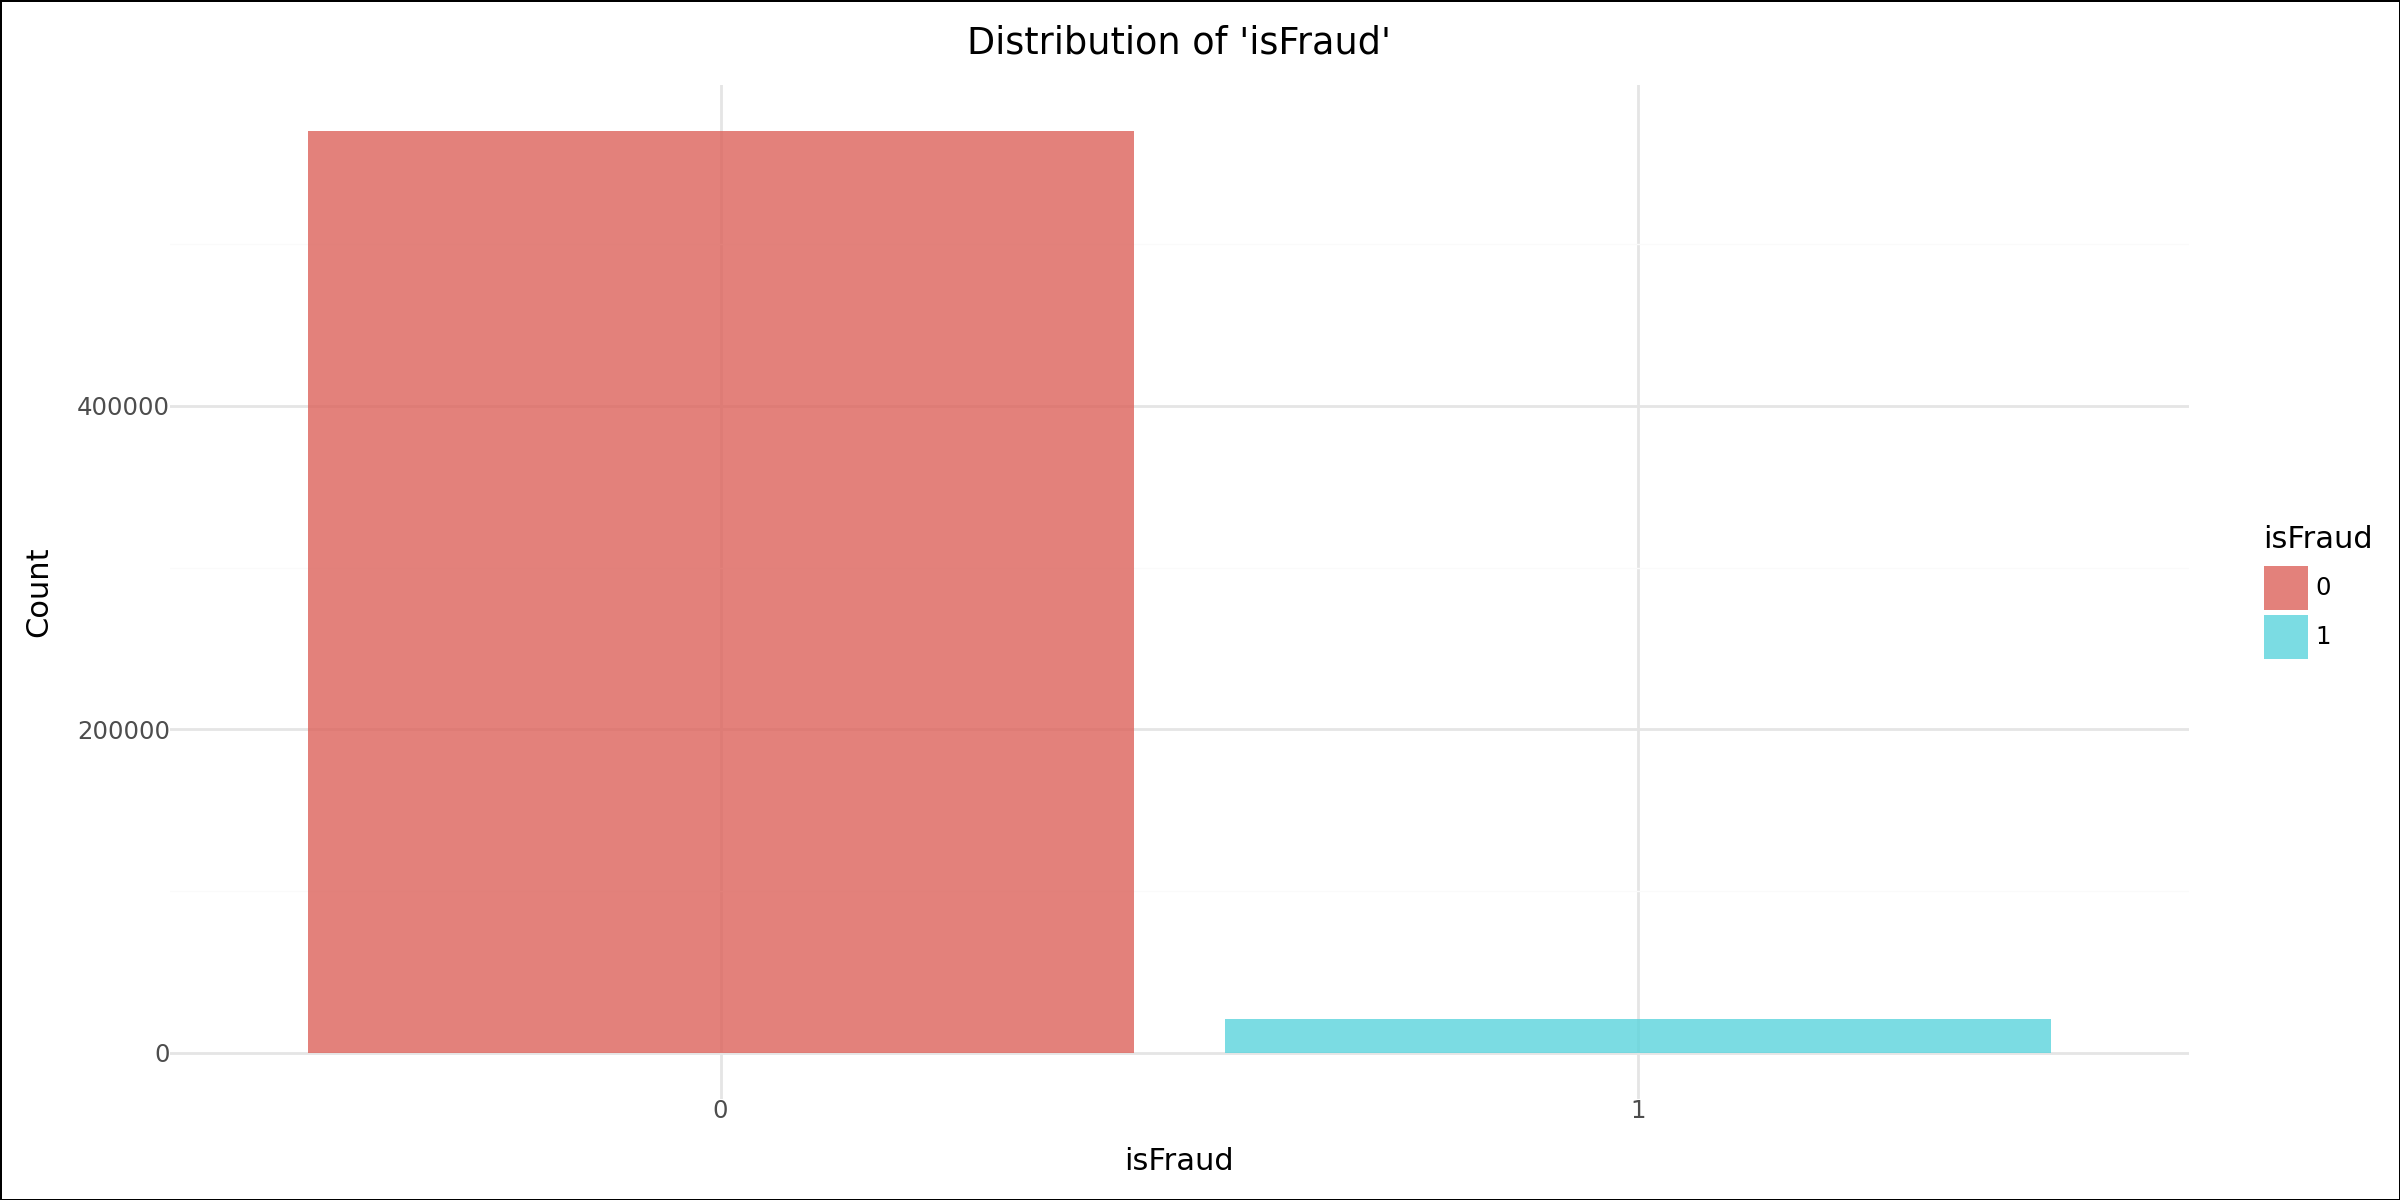

In [9]:
from plotnine import *

# 시각화 생성
(ggplot(df.loc[df["type"]=="train"])
 + geom_bar(aes(x='factor(isFraud)', fill='factor(isFraud)'), 
            stat='count', 
            alpha=0.8)
 + theme_minimal()
 + ggtitle("Distribution of 'isFraud'")
 + scale_fill_manual(values=['#DC625A', '#5AD4DC'], name="isFraud")
 + theme(
     figure_size=(12,6),
     axis_ticks=element_blank(),
     panel_border=element_blank(),
     plot_background=element_rect(fill='white'),  # 플롯 배경색 설정
     panel_background=element_rect(fill='white'),  # 패널 배경색 설정
 )
 + labs(x='isFraud', y='Count')
)

In [10]:
start_date = datetime.datetime.strptime("2017.12.01", "%Y.%m.%d") # 시작일 설정
df["time"] = df["TransactionDT"].apply(
    lambda x: datetime.timedelta(seconds=x) + start_date
)

print(df["time"].describe())

count                          1097231
mean     2018-06-08 20:37:19.798137856
min                2017-12-02 00:00:00
25%                2018-02-15 23:44:47
50%                2018-05-17 17:27:01
75%         2018-10-03 20:47:08.500000
max                2018-12-31 23:59:05
Name: time, dtype: object


## TransactionDT

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


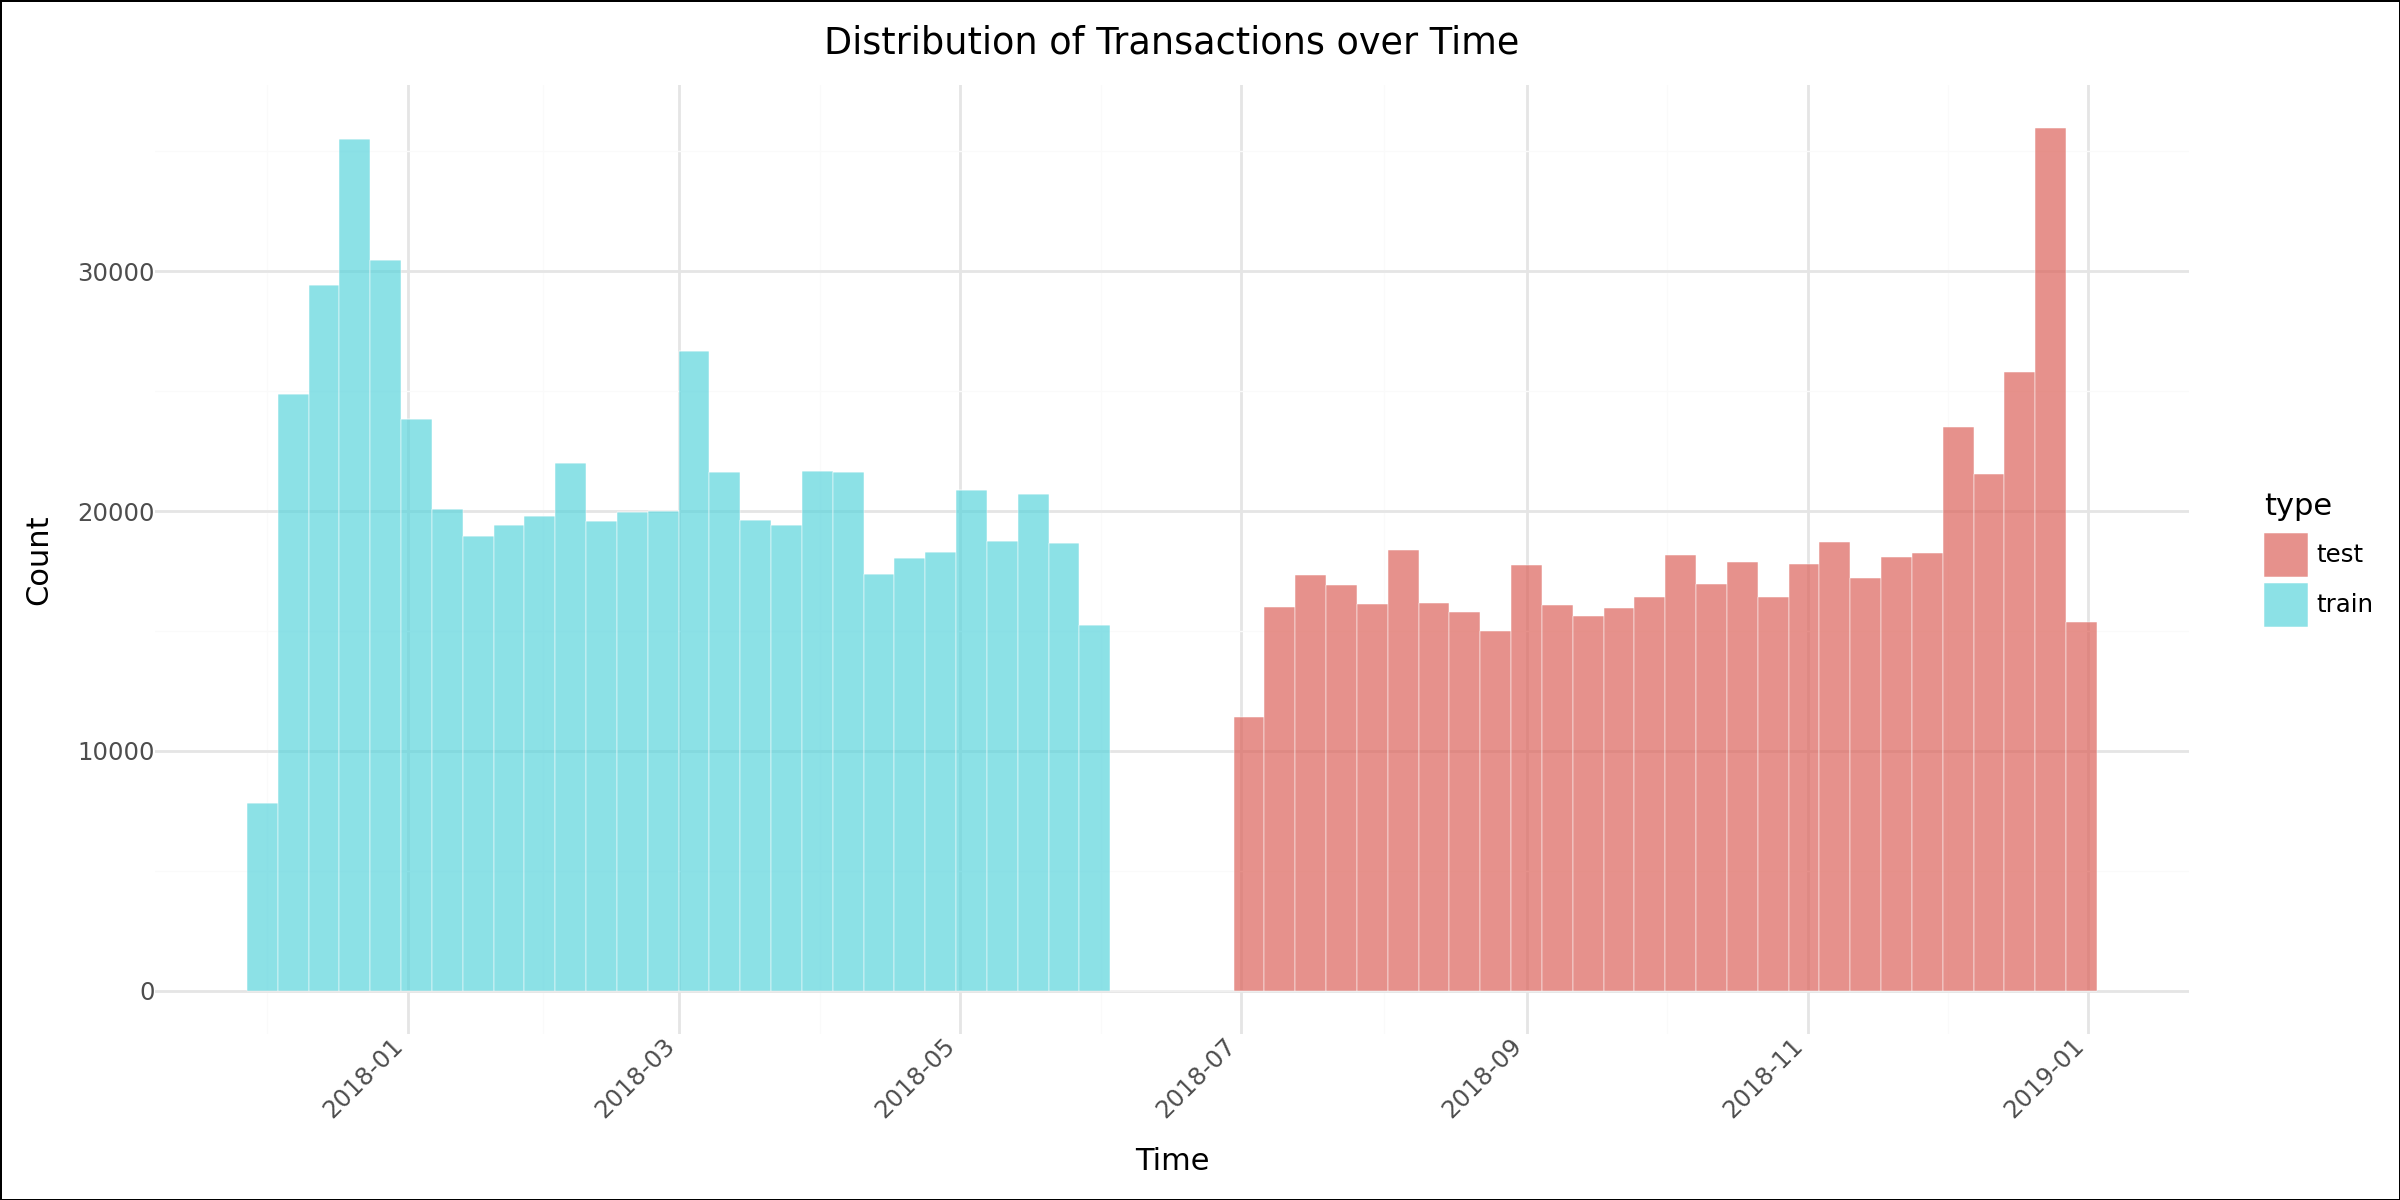

In [11]:
(ggplot(df)
 + geom_histogram(aes(x='time', fill='type'), 
                 alpha=0.7, 
                 bins=60, # bins로 구간 수 지정
                 color='white',
                 size=0.1)  
 + theme_minimal()
 + ggtitle("Distribution of Transactions over Time")
 + scale_x_datetime(date_breaks='2 month', date_labels='%Y-%m')  # 2달 간격으로 x축 표시
 + scale_fill_manual(values=['#DC625A', '#5AD4DC'], name="type")
 + theme(
     figure_size=(12,6),
     axis_ticks=element_blank(),
     panel_border=element_blank(),
     plot_background=element_rect(fill='white'),
     panel_background=element_rect(fill='white'),
     axis_text_x=element_text(angle=45, hjust=1),  # x축 레이블 회전
     legend_position='right'  # 범례를 아래로
 )
 + labs(x='Time', y='Count')
)

## ProductCD

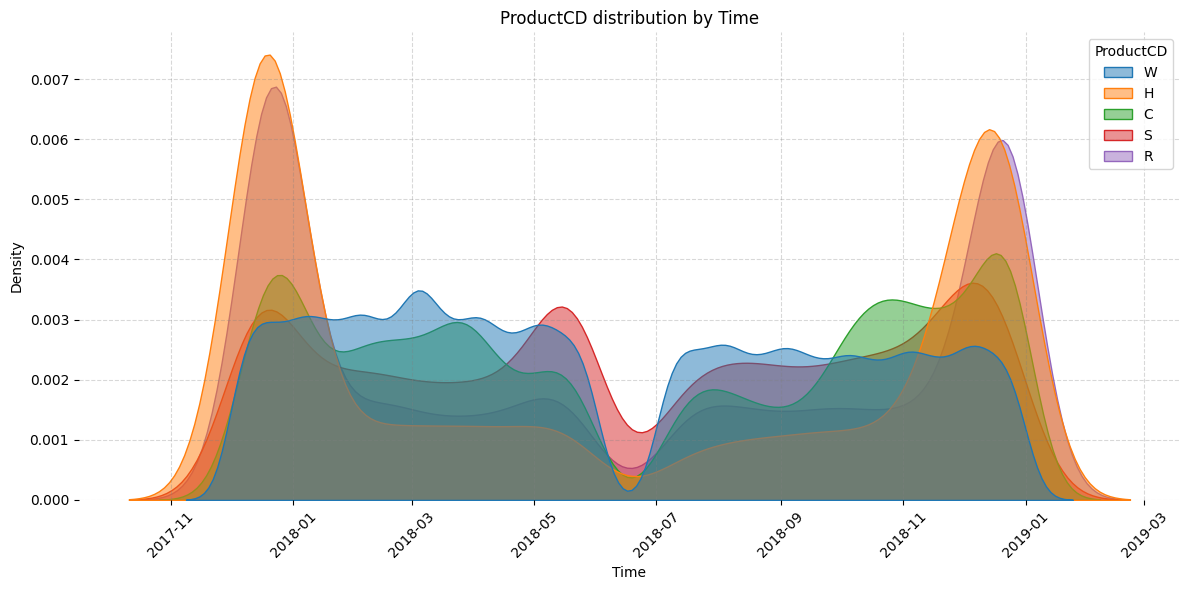

In [12]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# density plot 그리기
sns.kdeplot(data=df, 
            x='time',
            hue='ProductCD',
            fill=True,
            alpha=0.5,
            common_norm=False)

# 그래프 스타일링
plt.title('ProductCD distribution by Time')
plt.xlabel('Time')
plt.ylabel('Density')

# x축 레이블 회전
plt.xticks(rotation=45)

# 그리드
plt.grid(True, alpha=0.3, color='grey', linestyle='--')

# 배경 스타일 설정
sns.set_style("white")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

## D 변수

In [13]:
# D 컬럼들 선택
d_cols = [col for col in df.columns if col.startswith('D') and col[1:].isdigit() and int(col[1:]) <= 15]

# unique 개수와 NA 비율 계산
result = pd.DataFrame({
    'n_unique': df[d_cols].nunique(),
    'na_ratio': df[d_cols].isna().mean()
}).round(3)

# 컬럼명을 인덱스로 가지도록 설정
result.index.name = 'column'

# 결과 출력
print("D1-D15 컬럼들의 unique 값 개수와 NA 비율(%)")
result

D1-D15 컬럼들의 unique 값 개수와 NA 비율(%)


,n_unique,na_ratio
column,,
D1,642,0.007
D2,642,0.470
D3,888,0.425
D4,1069,0.224
D5,961,0.487
D6,1076,0.820
D7,905,0.910
D8,17082,0.864
D9,24,0.864


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 7300 rows containing missing values.


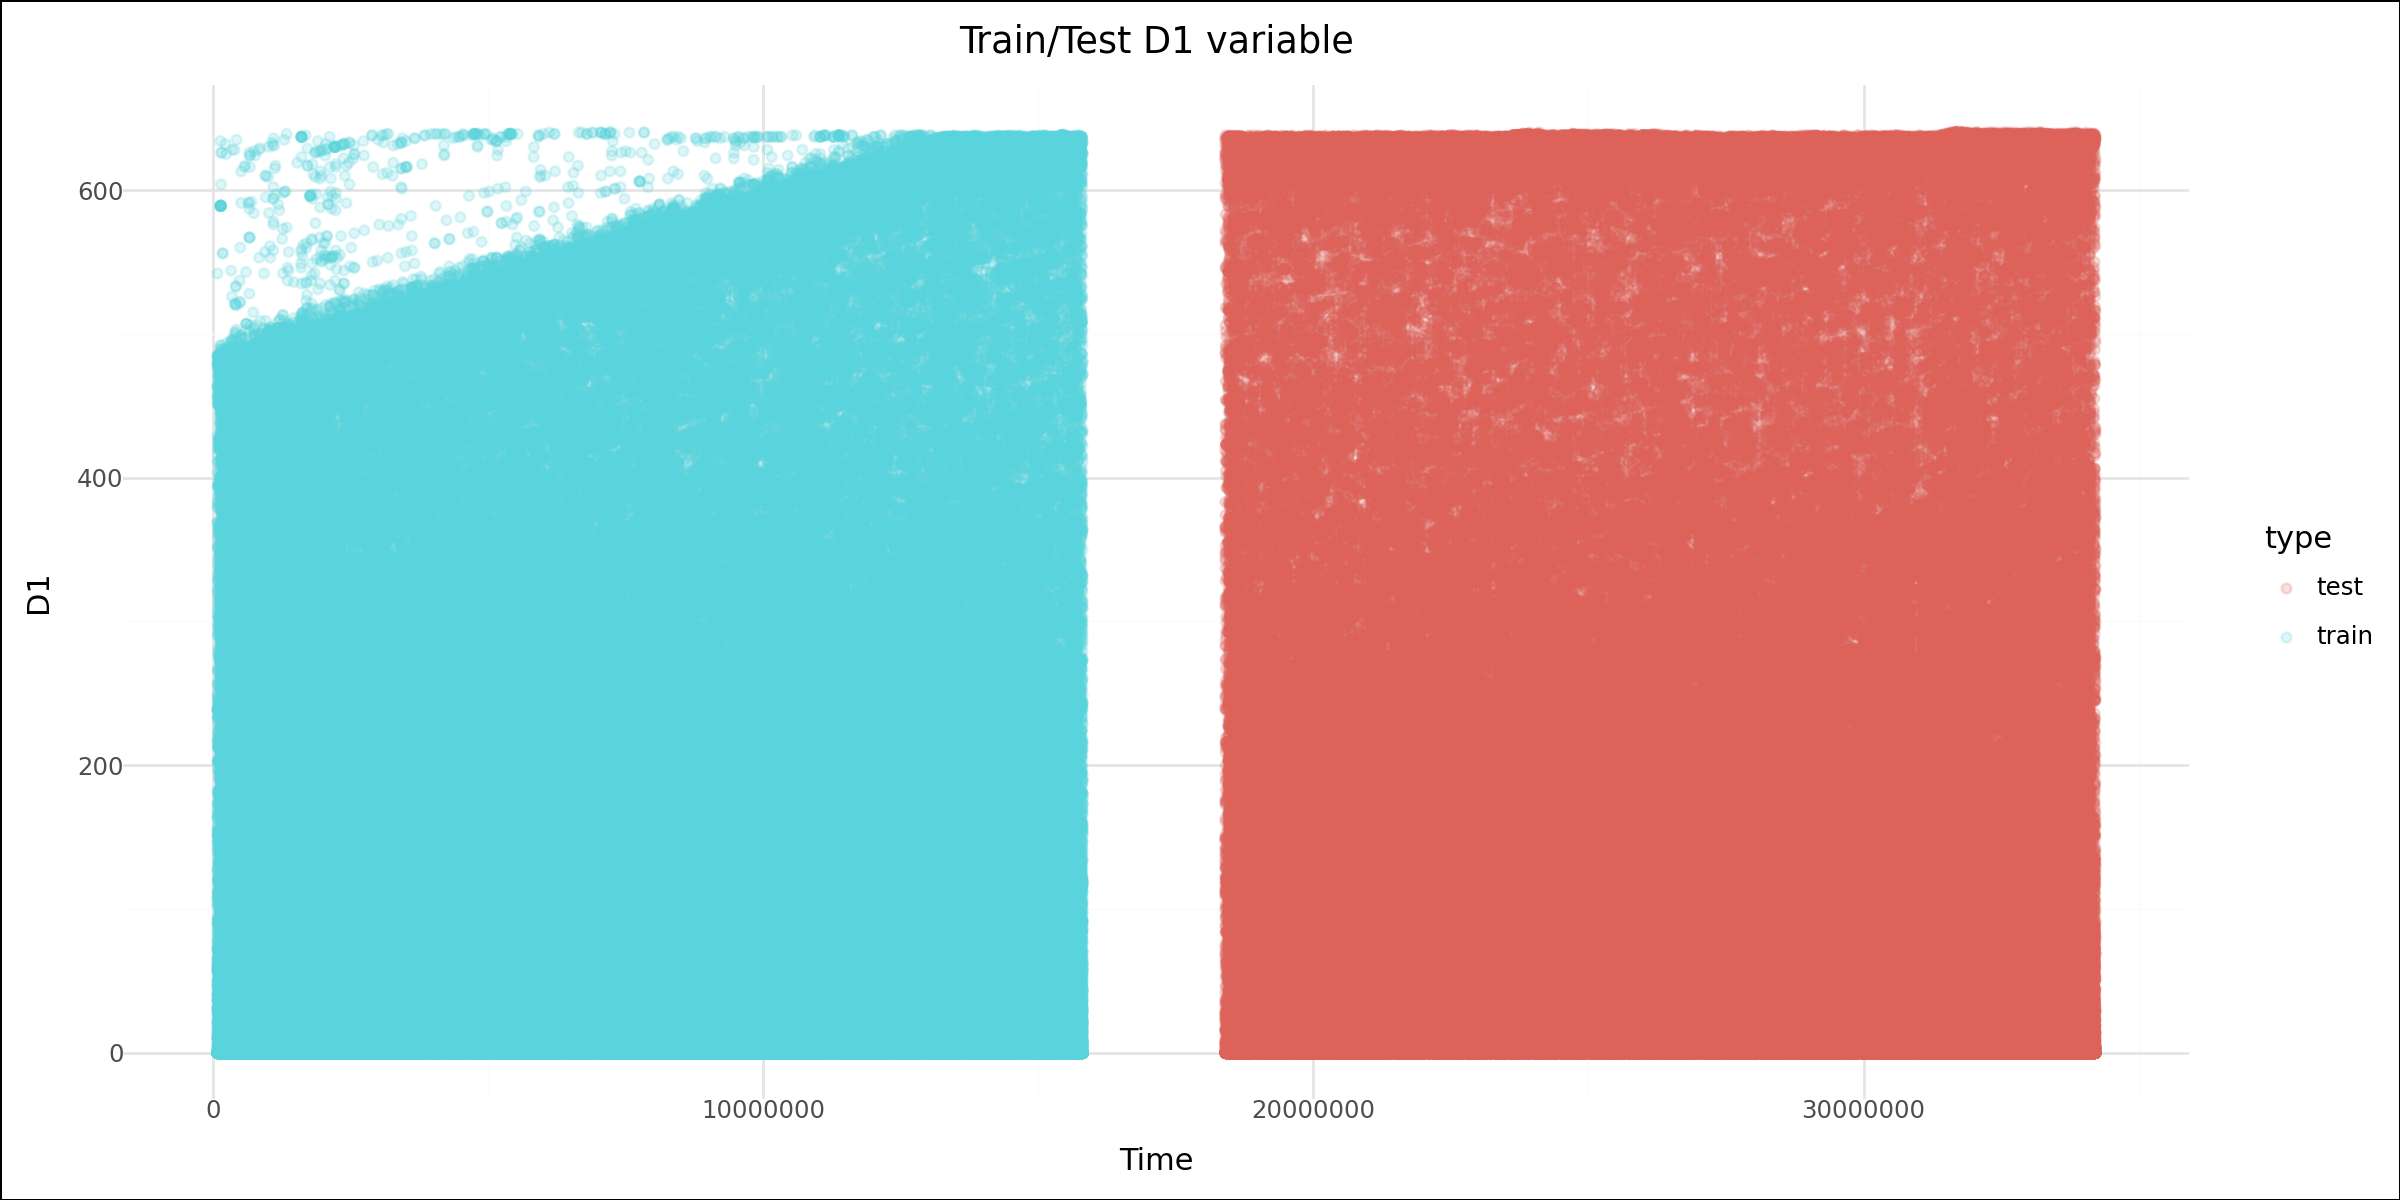

In [14]:
(ggplot(data = df) 
     + geom_point(aes(x='TransactionDT', y='D1', group='type', colour='type'), alpha=0.2)
     + theme_minimal()
     + scale_color_manual(values=['#DC625A', '#5AD4DC'], name="type")
     + ggtitle("Train/Test D1 variable") 
     + theme(
           legend_position="right", 
           figure_size=(12,6),
           plot_background=element_rect(fill='white'),
           panel_background=element_rect(fill='white'),
     )
     + labs(x='Time', y='D1')
)

# V 변수

In [21]:
v_cols = [col for col in df.columns if col.startswith('V') and col[1:].isdigit() and int(col[1:]) <= 340]
Vs = v_cols[-61:-18]

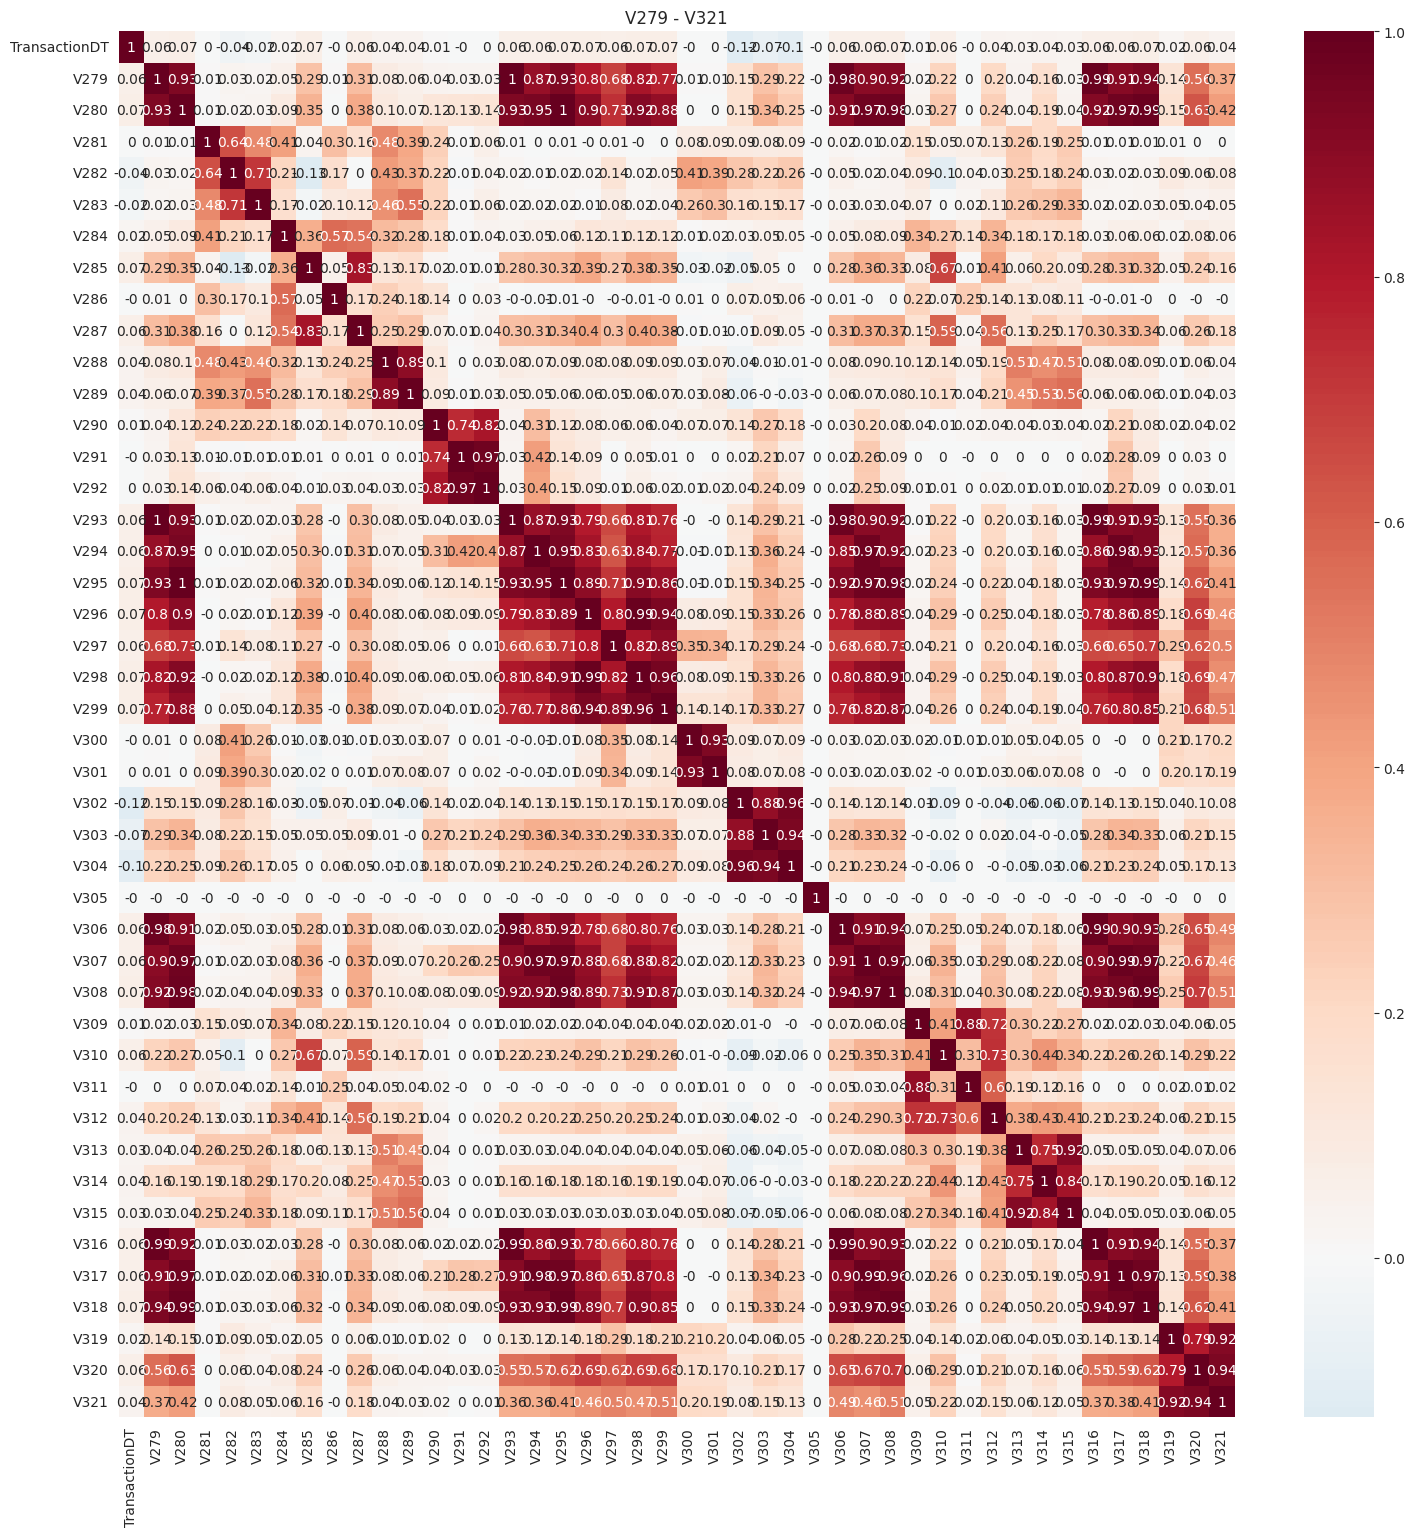

In [22]:
cols = ['TransactionDT'] + Vs
plt.figure(figsize=(18,18))
sns.heatmap(np.around(df.loc[df["type"]=="train", cols].corr(), 2), cmap='RdBu_r', annot=True, center=0.0)
plt.title(Vs[0] + " - " + Vs[-1], fontsize=12)
plt.show()

In [30]:
# unique 개수와 NA 비율 계산
result = pd.DataFrame({
    'n_unique': df[v_cols].nunique(),
    'na_sum': df[v_cols].isna().sum()
})

# 컬럼명을 인덱스로 가지도록 설정
result.index.name = 'column'

# 결과 출력
print("V 컬럼들의 unique 값 개수와 NA 갯수")
result

V 컬럼들의 unique 값 개수와 NA ratio


,n_unique,na_sum
column,,
V1,2,455805
V2,12,455805
V3,12,455805
V4,10,455805
V5,11,455805
...,...,...
V335,1021,938449
V336,504,938449
V337,437,938449


In [35]:
# na_sum을 기준으로 그룹화하고 해당하는 컬럼들을 리스트로 모으기
na_groups = result.groupby('na_sum').apply(lambda x: x.index.tolist()).reset_index()
na_groups.columns = ['na_count', 'columns']

# 컬럼 개수 추가
na_groups['column_count'] = na_groups['columns'].str.len()

# 2개 이상의 컬럼이 같은 na 개수를 가진 그룹만 필터링하고 정렬
na_groups_filtered = (na_groups[na_groups['column_count'] > 1]
                    .sort_values('na_count', ascending=False)
                    .reset_index(drop=True))

print("\n동일한 NA 개수를 가진 컬럼 그룹:")
na_groups_filtered


동일한 NA 개수를 가진 컬럼 그룹:


/tmp/ipykernel_6973/1920518846.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,na_count,columns,column_count
0,939501,"[V138, V139, V140, V141, V142, V146, V147, V14...",18
1,939225,"[V143, V144, V145, V150, V151, V152, V159, V16...",11
2,938449,"[V322, V323, V324, V325, V326, V327, V328, V32...",18
3,840073,"[V217, V218, V219, V223, V224, V225, V226, V22...",46
4,821037,"[V169, V170, V171, V174, V175, V180, V184, V18...",19
5,820866,"[V167, V168, V172, V173, V176, V177, V178, V17...",31
6,818499,"[V220, V221, V222, V227, V234, V238, V239, V24...",16
7,455805,"[V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11]",11
8,245823,"[V35, V36, V37, V38, V39, V40, V41, V42, V43, ...",18
9,101245,"[V75, V76, V77, V78, V79, V80, V81, V82, V83, ...",20
